## Import necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
train_path = '/content/drive/MyDrive/fraud/fraudTrain.csv'
test_path = '/content/drive/MyDrive/fraud/fraudTest.csv'

In [3]:
import pandas as pd
import numpy as np

import datetime

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

## Load Data

In [4]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
print('Shape of train data: ', train_data.shape)
print('columns name: ',train_data.columns)

Shape of train data:  (1296675, 23)
columns name:  Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [5]:
def preprocessing_data(dfin):

  dfout = dfin.drop_duplicates()
  print('Dropped the duplicates rows')

  print(f'There are {dfout.isna().sum().sum()} NA values in the data')
  dfout['trans_date_trans_time'] = pd.to_datetime(dfout['trans_date_trans_time'])
  print("Extracting time info from unique columns...")
  dfout.loc[:, 'age'] = datetime.date.today().year - pd.to_datetime(dfout['dob']).dt.year
  dfout.loc[:, 'hour'] = dfout['trans_date_trans_time'].dt.hour
  dfout.loc[:, 'dayofweek'] = dfout['trans_date_trans_time'].dt.dayofweek
  dfout.loc[:, 'month'] = dfout['trans_date_trans_time'].dt.month
  dfout.loc[:, 'year'] = dfout['trans_date_trans_time'].dt.year
  print("Finished")

  print("Dropped dob column...")
  dfout = dfout.drop(['dob'], axis = 1)
  print("Done.")
  return dfout

In [6]:
train_df = preprocessing_data(train_data)
test_df = preprocessing_data(test_data)
del train_data
del test_data
train_df.loc[:, 'is_train'] = 1
test_df.loc[:, 'is_train'] = 0
df = pd.concat([train_df, test_df])

Dropped the duplicates rows
There are 0 NA values in the data
Extracting time info from unique columns...
Finished
Dropped dob column...
Done.
Dropped the duplicates rows
There are 0 NA values in the data
Extracting time info from unique columns...
Finished
Dropped dob column...
Done.


In [7]:
df.head(2)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,unix_time,merch_lat,merch_long,is_fraud,age,hour,dayofweek,month,year,is_train
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,1325376018,36.011293,-82.048315,0,35,0,1,1,2019,1
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,1325376044,49.159047,-118.186462,0,45,0,1,1,2019,1


In [8]:
print(df.shape)

(1852394, 28)


## EDA

Checking target column

<Axes: >

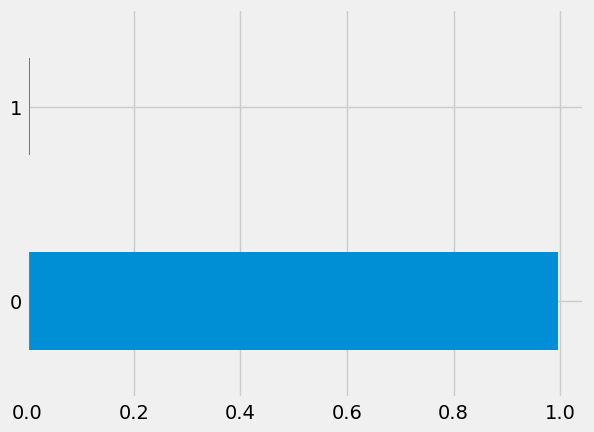

In [9]:
df.is_fraud.value_counts(normalize=True).plot(kind='barh')

The data is extremely imbalance

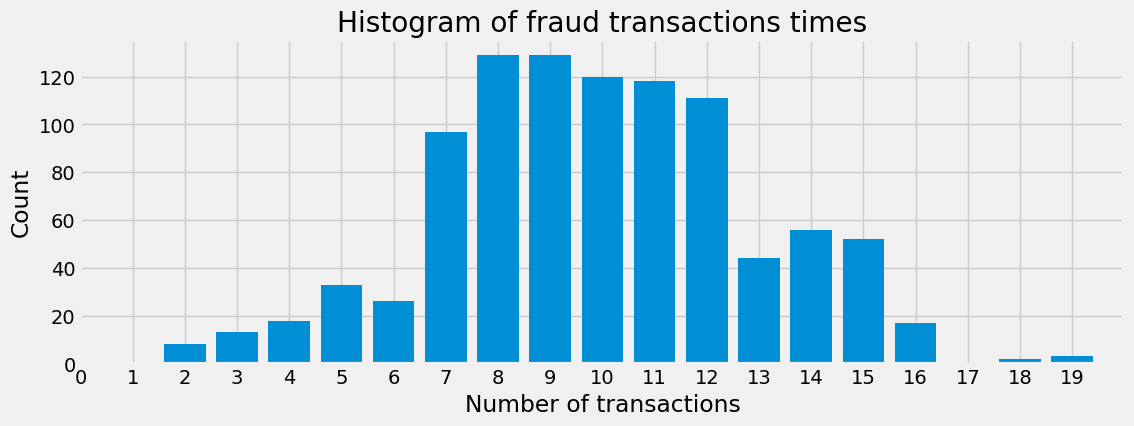

In [10]:
group = df[df.is_fraud == 1].groupby('cc_num')['is_fraud'].count().value_counts()
plt.figure(figsize=(12, 4))
plt.bar(x= group.index, height= group.values)
plt.xlabel('Number of transactions')
plt.ylabel('Count')
plt.title('Histogram of fraud transactions times')
plt.xlim(0, 20)
plt.xticks(np.arange(0, 20, 1))
plt.show()

People usually involved in 7-12 fraud transactions

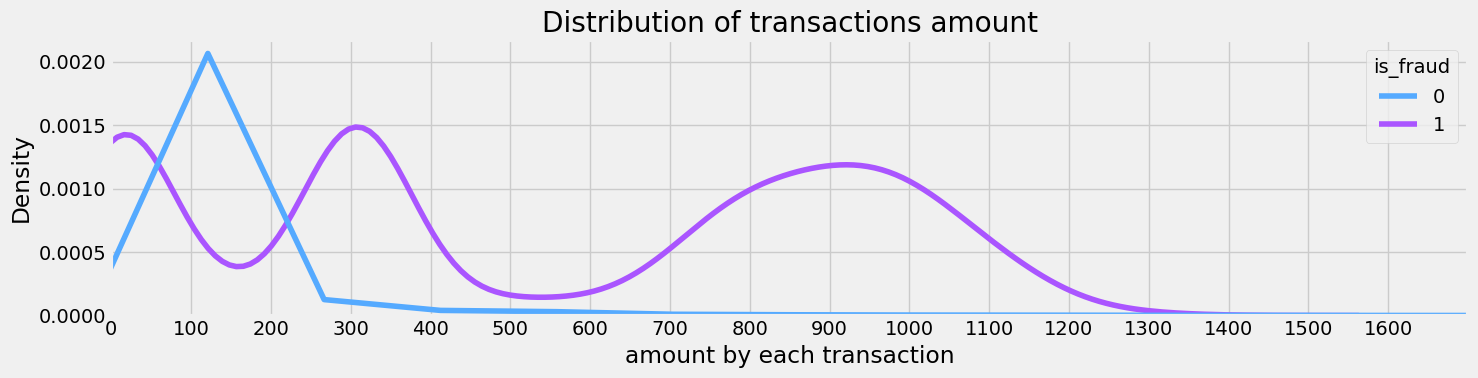

In [11]:
plt.figure(figsize=(15, 4))
sns.kdeplot(x = 'amt', data = df, hue='is_fraud', common_norm=False, palette ='cool')
plt.title('Distribution of transactions amount')
plt.xlabel('amount by each transaction')
plt.ylabel('Density')
plt.xlim(0, 1700)
plt.xticks(np.arange(0, 1700, 100))
plt.tight_layout()

Fraud transactions are likely to have amt value greater than 220

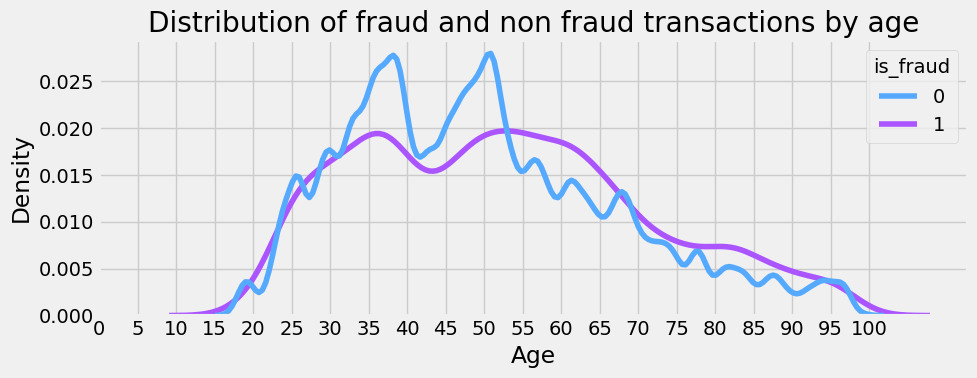

In [12]:
plt.figure(figsize=(10, 4))
sns.kdeplot(x = 'age', data = df, hue='is_fraud', common_norm=False, palette ='cool')
plt.title('Distribution of fraud and non fraud transactions by age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.xticks(np.arange(0, 105, 5))
plt.tight_layout()
plt.show()

Elder people whose age 53 and above are likely involved in fraud transactions

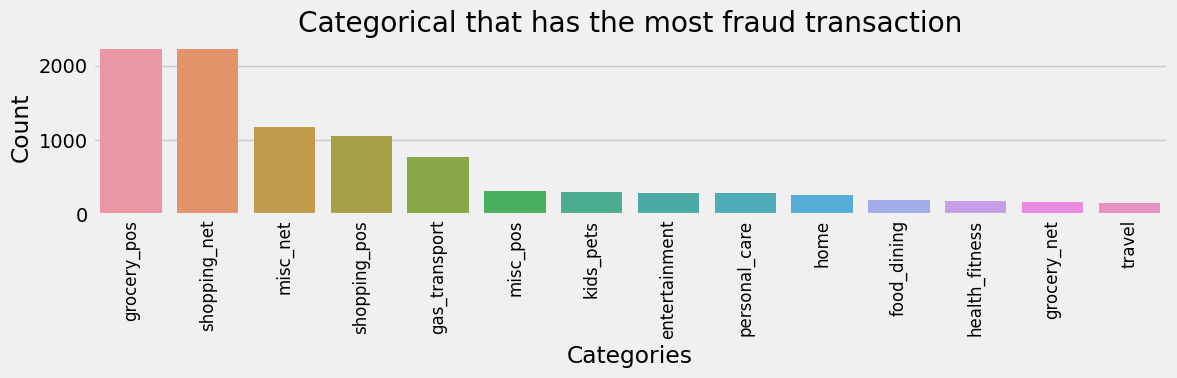

In [13]:
group = df[df.is_fraud == 1].groupby('category')['is_fraud'].count().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x=group.category, y=group.is_fraud)
plt.xticks(rotation='vertical', fontsize=12)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Categorical that has the most fraud transaction')
plt.tight_layout()
plt.show()

We can clearly see the top 5 kind of transactions that have the most fraud cases

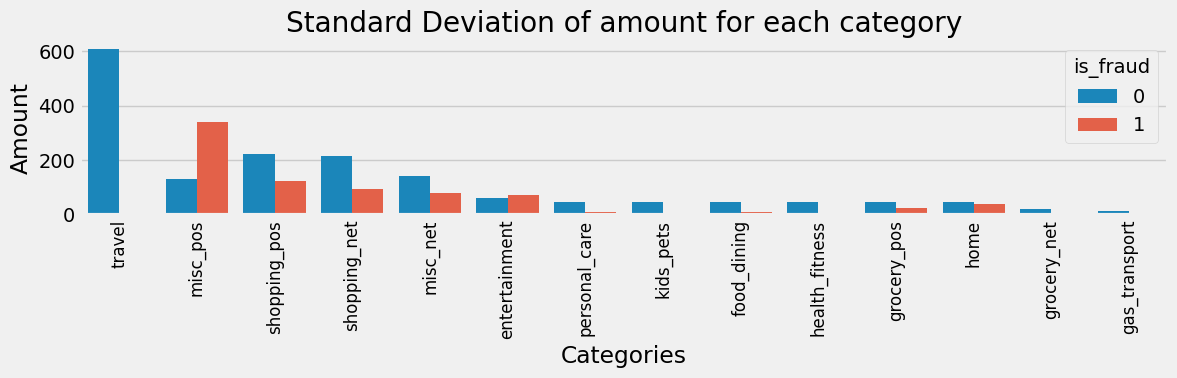

In [14]:
group = df.groupby(['category', 'is_fraud'])['amt'].std().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 4))
sns.barplot(x=group.category, y=group.amt, hue= group.is_fraud)
plt.xticks(rotation='vertical', fontsize=12)
plt.xlabel('Categories')
plt.ylabel('Amount')
plt.title('Standard Deviation of amount for each category')
plt.tight_layout()
plt.show()

If the amount in transaction of misc_pos of a person increased, it's likely that a fraud transaction

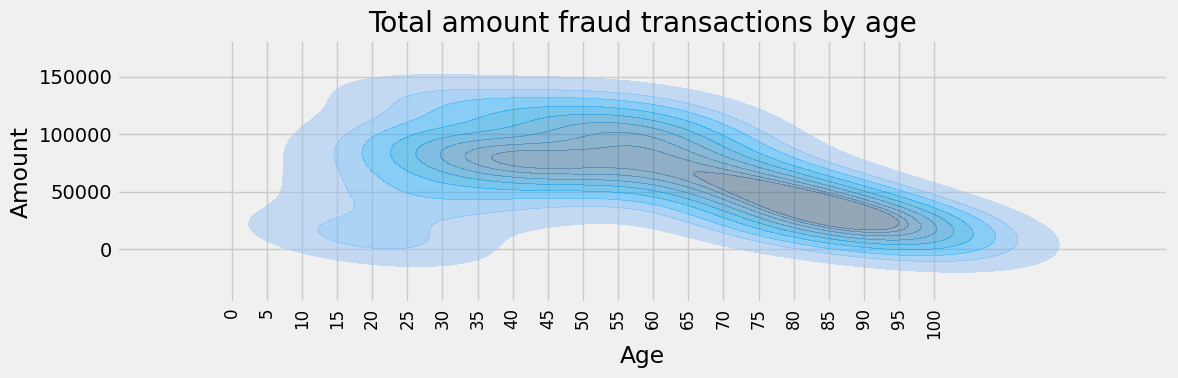

In [15]:
group = df[df.is_fraud == 1].groupby(['age'])['amt'].sum().reset_index()
plt.figure(figsize=(12, 4))
sns.kdeplot(data=group, x="age", y= 'amt',fill=True, common_norm=False, alpha=.5)
plt.xticks(rotation='vertical', fontsize=12)
plt.xlabel('Age')
plt.xticks(np.arange(0, 105, 5))
plt.ylabel('Amount')
plt.title('Total amount fraud transactions by age')
plt.tight_layout()
plt.show()

Elder in 65-95 have the biggest amount in fraud transactions

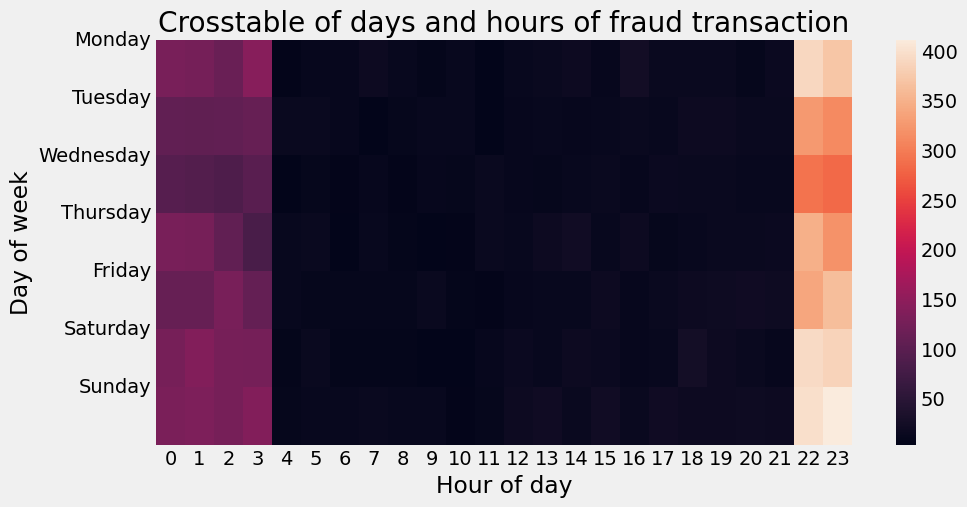

In [16]:
group = df[df.is_fraud == 1].groupby(['dayofweek','hour'])['trans_num'].count().reset_index()
group = group.pivot(index = 'dayofweek',
                      columns='hour',
                      values='trans_num')
plt.figure(figsize=(10, 5))
sns.heatmap(group)
plt.yticks([0,1, 2, 3, 4, 5, 6],["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xlabel("Hour of day")
plt.yticks(rotation=0)
plt.ylabel("Day of week")
plt.title("Crosstable of days and hours of fraud transaction");

Fraud transactions usually happen from 22PM - 3AM

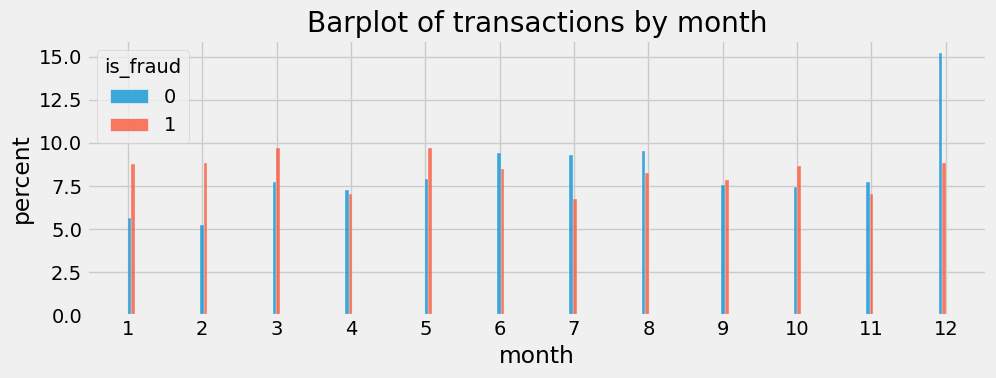

In [17]:
plt.figure(figsize=(10, 4))
sns.histplot(x = 'month',data=df,hue='is_fraud',
              stat='percent', multiple='dodge',
             common_norm=False)
plt.xlabel('month')
plt.ylabel('percent')
plt.title('Barplot of transactions by month')
plt.xticks(np.arange(1, 13, 1))
plt.tight_layout()

Fraud transactions happen lots in the first quarter of the year

In [18]:
print(f'There are {len(df.city.unique())} cities in the dataset')
print(f'There are {len(df.state.unique())} states in the dataset')
print(f'There are {len(df.street.unique())} streets in the dataset')
print(f'There are {len(df.job.unique())} jobs in the dataset')

There are 906 cities in the dataset
There are 51 states in the dataset
There are 999 streets in the dataset
There are 497 jobs in the dataset


Split credit card by types

In [19]:
def get_card_type(example):
  if str(example).startswith('34') or str(example).startswith('37'):
    return 'AE'
  elif str(example).startswith('4'):
    return 'Visa'
  elif str(example).startswith('5'):
    return 'MC'
  elif str(example).startswith('6'):
    return 'DC'
  else: return 'Unknown'

In [20]:
df.loc[:, 'card_type'] = df['cc_num'].map(get_card_type)

In [21]:
group = df.groupby('card_type')['is_fraud'].value_counts(normalize=True).reset_index(name='count')
group

,card_type,is_fraud,count
0,AE,0,0.994929
1,AE,1,0.005071
2,DC,0,0.994601
3,DC,1,0.005399
4,MC,0,0.993983
5,MC,1,0.006017
6,Unknown,0,0.994860
7,Unknown,1,0.005140
8,Visa,0,0.994852
9,Visa,1,0.005148


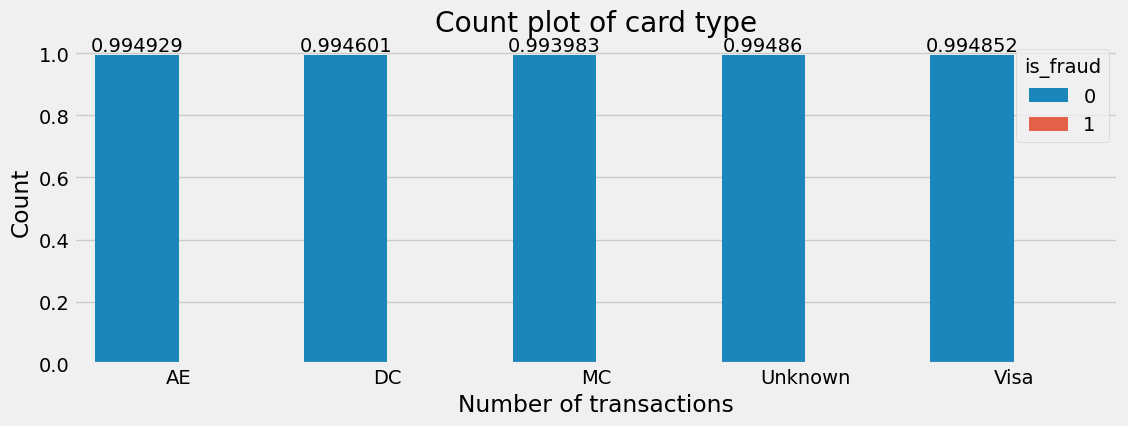

In [22]:
plt.figure(figsize=(12, 4))
ax = sns.barplot(x='card_type',y='count', hue='is_fraud', data=group)
ax.bar_label(ax.containers[0])
plt.xlabel('Number of transactions')
plt.ylabel('Count')
plt.title('Count plot of card type')
plt.show()

## Statistical

In [23]:
from scipy import stats

In [24]:
def m_test(a, b):
  alpha=0.05
  stat, pval = stats.mannwhitneyu(a, b)

  print('Statistic:', f'{stat:.3f}')
  print('P-Value:', f'{pval:.20f}')

  # Checking the condition for accepting or rejecting H0
  if pval > alpha:
      print('Accept H0 - There is no significant difference between the groups.')
  if pval < alpha:
      print('Reject H0 - There are significant differences between the groups.')

H0: All age involved in fraud transactions equally  
H1: Elder whose age > 53 and above are likely to involved in fraud transactions

In [25]:
left = df.loc[df['age'] >=53]['is_fraud']
right = df.loc[df['age'] <53]['is_fraud']
m_test(left, right)

Statistic: 403565495327.000
P-Value: 0.00000000000000000000
Reject H0 - There are significant differences between the groups.


We accept H1, Elder whose age > 53 and above are likely to involved in fraud transactions

## Feature engineering and selection

In [23]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'age', 'hour', 'dayofweek', 'month', 'year',
       'is_train', 'card_type'],
      dtype='object')

In [24]:
# info from EDA
df.loc[:, 'is_midnight'] = [1 if x in [22, 23, 0, 1, 2, 3] else 0 for x in df.hour.values]
df.loc[:, 'is_elder'] = [1 if x> 53 else 0 for x in df.age.values]

In [25]:
features = ['category','amt','gender','state','age','hour', 'month','is_midnight','is_elder','is_fraud', 'card_type']
train_df = df[df.is_train == 1][features]
test_df = df[df.is_train == 0][features]

In [26]:
from sklearn.preprocessing import OrdinalEncoder

In [27]:
category_features = ['category','gender','state', 'card_type']
for col in category_features:
  print(col)
  oe = OrdinalEncoder()
  oe.fit(train_df[col].values.reshape(-1, 1))
  train_df.loc[:, col] = oe.transform(train_df[col].values.reshape(-1, 1))
  test_df.loc[:, col] = oe.transform(test_df[col].values.reshape(-1, 1))


category


<ipython-input-27-3b9e4a2d23c4>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_df.loc[:, col] = oe.transform(train_df[col].values.reshape(-1, 1))
<ipython-input-27-3b9e4a2d23c4>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_df.loc[:, col] = oe.transform(test_df[col].values.reshape(-1, 1))


gender


<ipython-input-27-3b9e4a2d23c4>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_df.loc[:, col] = oe.transform(train_df[col].values.reshape(-1, 1))
<ipython-input-27-3b9e4a2d23c4>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_df.loc[:, col] = oe.transform(test_df[col].values.reshape(-1, 1))


state


<ipython-input-27-3b9e4a2d23c4>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_df.loc[:, col] = oe.transform(train_df[col].values.reshape(-1, 1))
<ipython-input-27-3b9e4a2d23c4>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_df.loc[:, col] = oe.transform(test_df[col].values.reshape(-1, 1))


card_type


<ipython-input-27-3b9e4a2d23c4>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_df.loc[:, col] = oe.transform(train_df[col].values.reshape(-1, 1))
<ipython-input-27-3b9e4a2d23c4>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_df.loc[:, col] = oe.transform(test_df[col].values.reshape(-1, 1))


In [28]:
train_df.shape, test_df.shape

((1296675, 11), (555719, 11))

In [29]:
train_df.loc[:,'amt_qcut'], bins = pd.qcut(train_df.amt, q = 20,labels = list(np.arange(0, 20, 1)), retbins = True)
train_df = train_df.loc[train_df.amt_qcut.isin([19, 6, 5, 4, 3, 17, 10, 7])]
train_df['log1p_amt'] = np.log1p(train_df.amt.values)
test_df['log1p_amt'] = np.log1p(test_df.amt.values)

<ipython-input-29-ff7f26e0cc4f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['log1p_amt'] = np.log1p(train_df.amt.values)


In [30]:
train_df.shape, test_df.shape

((518369, 13), (555719, 12))

In [31]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
import xgboost as xgb

In [32]:
train_df.loc[:, 'kfold'] = -1
train_df = train_df.sample(frac=1).reset_index(drop=True)
y = train_df.is_fraud.values
kf = model_selection.StratifiedKFold(n_splits= 5)
for f, (t_, v_) in enumerate(kf.split(X= train_df, y = y)):
  train_df.loc[v_, 'kfold'] = f

In [33]:
train_df.loc[train_df.kfold == 1].is_fraud.value_counts()

0    102191
1      1483
Name: is_fraud, dtype: int64

## Init Metrics

In [34]:
def generate_report(y_test, test_preds):
  print("accuracy: %.2f, sensitivity: %.2f, specificity:\
  %.2f, precision: %.2f"  %
    (metrics.accuracy_score(y_test.ravel(), test_preds),
    metrics.recall_score(y_test.ravel(), test_preds),
    metrics.recall_score(y_test.ravel(), test_preds,pos_label=0),
    metrics.precision_score(y_test.ravel(),test_preds)))

## Load model

In [35]:
train_df.head(2)

,category,amt,gender,state,age,hour,month,is_midnight,is_elder,is_fraud,card_type,amt_qcut,log1p_amt,kfold
0,6.0,235.13,1.0,12.0,59,19,5,0,1,0,4.0,19,5.464383,0
1,11.0,1339.37,0.0,48.0,81,8,12,0,1,0,3.0,19,7.200701,0


In [59]:
log_importances = {}
log_cm = {}
log_xgb = {}
def cv_train(fold, model ='lr',remove_col=None, params = None, iters = None, use_shap = None):
  train = train_df[train_df.kfold != fold].reset_index(drop=True)
  valid = train_df[train_df.kfold == fold].reset_index(drop=True)

  features = [x for x in train.columns if x not in remove_col]
  print('features: ', features)
  X_train = train[features].values
  X_valid = valid[features].values

  X_test = test_df[features].values

  if model == 'lr':
    lr = linear_model.LogisticRegression()
    lr.fit(X_train, train_df.is_fraud.values)
    preds = lr.predict_proba(X_valid)[:, 1]

    auc = metrics.roc_auc_score(valid.is_fraud.values, preds)

    print(f'Fold: {fold}, AUC = {auc}')

  elif model == 'xgb':
    model = xgb.XGBClassifier(n_jobs = -1,
                              max_depth = 6,
                              n_estimators = 200,
                              eta = 0.1,  #lr
                              alpha = 0.5 # lasso
                              )
    model.fit(X_train, train.is_fraud.values)
    preds = model.predict_proba(X_valid)[:, 1]
    auc = metrics.roc_auc_score(valid.is_fraud.values, preds)
    print(f'Fold: {fold}, AUC = {auc}')
    test_preds = model.predict_proba(X_test)[:,1]
    test_auc = metrics.roc_auc_score(test_df.is_fraud.values, test_preds)
    print("test auc score is: ", test_auc)
    test_preds_notproba = model.predict(X_test)
    print(f'report on fold: {fold}')
    generate_report(test_df.is_fraud.values,test_preds_notproba )
    print('-'*10)
    print()
    log_cm[fold] = metrics.confusion_matrix(test_df.is_fraud.values, test_preds_notproba)
    log_xgb[fold] = model.get_booster().get_score(importance_type='weight')

  elif model == 'random_search':
    classifier = xgb.XGBClassifier(njobs = -1)
    model = model_selection.RandomizedSearchCV(
        estimator = classifier,
        param_distributions = params,
        n_iter = iters,
        scoring= 'roc_auc',
        verbose = 10,
        cv= 5,
        n_jobs =-1
    )
    model.fit(X_train, train.is_fraud.values)
    print(f"Best score: {model.best_score_}")
    print("Best parameters set:")
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
      print(f"\t{param_name}: {best_parameters[param_name]}")

In [37]:
remove_col = ['amt_qcut', 'is_fraud','kfold', 'amt']
for i in range(5):
  cv_train(i, model = 'xgb', remove_col = remove_col)

features:  ['category', 'gender', 'state', 'age', 'hour', 'month', 'is_midnight', 'is_elder', 'card_type', 'log1p_amt']
Fold: 0, AUC = 0.9973637679362233
test auc score is:  0.9931754608912498
report on fold: 0
accuracy: 1.00, sensitivity: 0.74, specificity:  1.00, precision: 0.92
----------

features:  ['category', 'gender', 'state', 'age', 'hour', 'month', 'is_midnight', 'is_elder', 'card_type', 'log1p_amt']
Fold: 1, AUC = 0.997737389045395
test auc score is:  0.9938877536649469
report on fold: 1
accuracy: 1.00, sensitivity: 0.73, specificity:  1.00, precision: 0.93
----------

features:  ['category', 'gender', 'state', 'age', 'hour', 'month', 'is_midnight', 'is_elder', 'card_type', 'log1p_amt']
Fold: 2, AUC = 0.997954572563944
test auc score is:  0.9933877600780309
report on fold: 2
accuracy: 1.00, sensitivity: 0.73, specificity:  1.00, precision: 0.93
----------

features:  ['category', 'gender', 'state', 'age', 'hour', 'month', 'is_midnight', 'is_elder', 'card_type', 'log1p_amt']


In [38]:
def show_features(model_log, features, fold):
  idxs = np.argsort(np.array(list(model_log[fold].values())))

  plt.title('Feature Importances')
  plt.barh(range(len(idxs)), np.array(list(model_log[fold].values()))[idxs], align='center')
  plt.yticks(range(len(idxs)), [features[i] for i in idxs])
  plt.xlabel('XGB Feature Importance')
  plt.show()

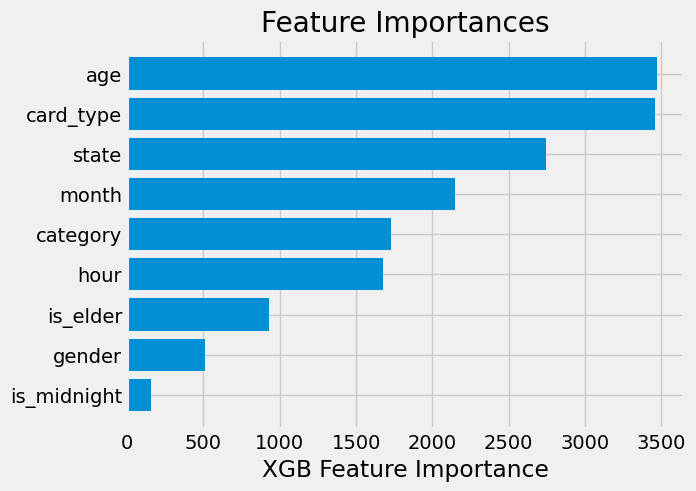

In [39]:
col = ['category', 'gender', 'state', 'age', 'hour', 'month', 'is_midnight', 'is_elder', 'card_type', 'log1p_amt']
show_features(log_xgb, col, fold = 3)

The midnight feature is the least importance  
This could be because we got Hour feature in there

## More feature engineering and hyperparameter searching

In [44]:
# Return to freature engineering
# load back data
features = ['merchant','category','job','amt','gender','state','age','hour', 'month','is_midnight','is_elder','is_fraud', 'card_type']
train_df = df[df.is_train == 1][features]
test_df = df[df.is_train == 0][features]
# feature engineering
mapping_dict_cate = dict(train_df.groupby('category')["amt"].std())
mapping_dict_card = dict(train_df.groupby('card_type')['amt'].std())
#mapping_dict_amt = dict(train_df.groupby('job')['amt'].std())
mapping_dict_mer = dict(train_df.groupby('merchant')['amt'].mean())
train_df.loc[:, 'cate_enc'] = train_df['category'].map(mapping_dict_cate)
train_df.loc[:, 'card_enc'] = train_df['card_type'].map(mapping_dict_card)
#train_df.loc[:, 'amt_enc'] = train_df['job'].map(mapping_dict_amt)
train_df.loc[:, 'mer_enc'] = train_df['merchant'].map(mapping_dict_mer)
test_df.loc[:, 'cate_enc'] = test_df['category'].map(mapping_dict_cate)
test_df.loc[:, 'card_enc'] = test_df['card_type'].map(mapping_dict_card)
#test_df.loc[:, 'amt_enc'] = test_df['job'].map(mapping_dict_amt)
test_df.loc[:, 'mer_enc'] = test_df['merchant'].map(mapping_dict_mer)
# filter
train_df.loc[:,'amt_qcut'], bins = pd.qcut(train_df.amt, q = 20,labels = list(np.arange(0, 20, 1)), retbins = True)
train_df = train_df.loc[train_df.amt_qcut.isin([19, 6, 5, 4, 3, 17, 10, 7])]
train_df['log1p_amt'] = np.log1p(train_df.amt.values)
test_df['log1p_amt'] = np.log1p(test_df.amt.values)

<ipython-input-44-4b67e89ed1d1>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['log1p_amt'] = np.log1p(train_df.amt.values)


In [45]:
category_features = ['category','gender','state', 'card_type']
for col in category_features:
  print(col)
  oe = OrdinalEncoder()
  oe.fit(train_df[col].values.reshape(-1, 1))
  train_df.loc[:, col] = oe.transform(train_df[col].values.reshape(-1, 1))
  test_df.loc[:, col] = oe.transform(test_df[col].values.reshape(-1, 1))


category


<ipython-input-45-3b9e4a2d23c4>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_df.loc[:, col] = oe.transform(train_df[col].values.reshape(-1, 1))
<ipython-input-45-3b9e4a2d23c4>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_df.loc[:, col] = oe.transform(test_df[col].values.reshape(-1, 1))


gender


<ipython-input-45-3b9e4a2d23c4>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_df.loc[:, col] = oe.transform(train_df[col].values.reshape(-1, 1))
<ipython-input-45-3b9e4a2d23c4>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_df.loc[:, col] = oe.transform(test_df[col].values.reshape(-1, 1))


state


<ipython-input-45-3b9e4a2d23c4>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_df.loc[:, col] = oe.transform(train_df[col].values.reshape(-1, 1))
<ipython-input-45-3b9e4a2d23c4>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_df.loc[:, col] = oe.transform(test_df[col].values.reshape(-1, 1))


card_type


<ipython-input-45-3b9e4a2d23c4>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_df.loc[:, col] = oe.transform(train_df[col].values.reshape(-1, 1))
<ipython-input-45-3b9e4a2d23c4>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_df.loc[:, col] = oe.transform(test_df[col].values.reshape(-1, 1))


In [46]:
train_df.loc[:, 'kfold'] = -1
train_df = train_df.sample(frac=1).reset_index(drop=True)
y = train_df.is_fraud.values
kf = model_selection.StratifiedKFold(n_splits= 5)
for f, (t_, v_) in enumerate(kf.split(X= train_df, y = y)):
  train_df.loc[v_, 'kfold'] = f

In [47]:
train_df.columns

Index(['merchant', 'category', 'job', 'amt', 'gender', 'state', 'age', 'hour',
       'month', 'is_midnight', 'is_elder', 'is_fraud', 'card_type', 'cate_enc',
       'card_enc', 'mer_enc', 'amt_qcut', 'log1p_amt', 'kfold'],
      dtype='object')

In [48]:
remove_col = ['merchant', 'job','amt','month' ,'amt_qcut', 'is_fraud','kfold', 'is_midnight']
for i in range(5):
  cv_train(i, model = 'xgb', remove_col = remove_col)

features:  ['category', 'gender', 'state', 'age', 'hour', 'is_elder', 'card_type', 'cate_enc', 'card_enc', 'mer_enc', 'log1p_amt']
Fold: 0, AUC = 0.9968855966581373
test auc score is:  0.9949336152327984
report on fold: 0
accuracy: 1.00, sensitivity: 0.78, specificity:  1.00, precision: 0.90
----------

features:  ['category', 'gender', 'state', 'age', 'hour', 'is_elder', 'card_type', 'cate_enc', 'card_enc', 'mer_enc', 'log1p_amt']
Fold: 1, AUC = 0.9968921654796938
test auc score is:  0.9949507006485838
report on fold: 1
accuracy: 1.00, sensitivity: 0.77, specificity:  1.00, precision: 0.89
----------

features:  ['category', 'gender', 'state', 'age', 'hour', 'is_elder', 'card_type', 'cate_enc', 'card_enc', 'mer_enc', 'log1p_amt']
Fold: 2, AUC = 0.9970150661184717
test auc score is:  0.9945620445999799
report on fold: 2
accuracy: 1.00, sensitivity: 0.77, specificity:  1.00, precision: 0.90
----------

features:  ['category', 'gender', 'state', 'age', 'hour', 'is_elder', 'card_type', 'c

We managed to increase the sensitivity/recall score with a cost of precision.  
A little trade off for better fraud detections

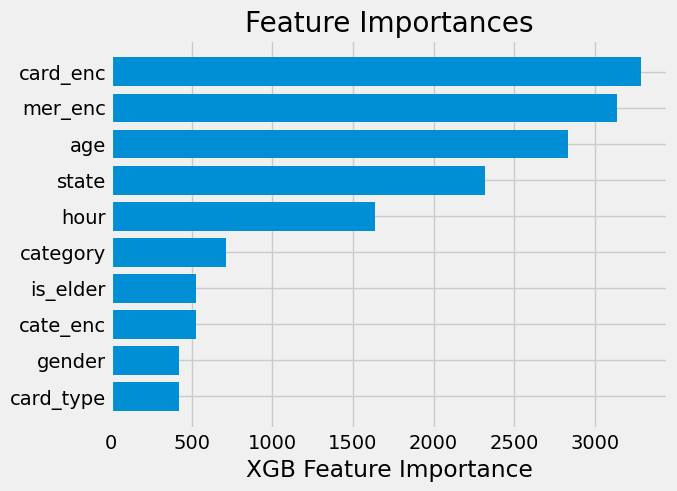

In [49]:
col = ['category', 'gender', 'state', 'age', 'hour', 'is_elder', 'card_type', 'cate_enc', 'card_enc', 'mer_enc', 'log1p_amt']
show_features(log_xgb, col, fold = 4)

We can see that our feature engineer works have done a good job for model to predict the target

## Interpret model

In [50]:
!pip install shap
import shap

train = train_df[train_df.kfold != 4].reset_index(drop=True)

X_train = train[col].values
model = xgb.XGBClassifier(n_jobs = -1,
                          max_depth = 7,
                          n_estimators = 250,
                          eta = 0.3,  #lr
                          alpha = 0.5 # lasso
                          )
model.fit(X_train, train.is_fraud.values)
explainer = shap.Explainer(model)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.7 MB/s eta 0:00:00


[05:38:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[05:38:29] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [52]:
X_samples = test_df[test_df.is_fraud == 1].sample(100)
shap_values = explainer(X_samples[col])

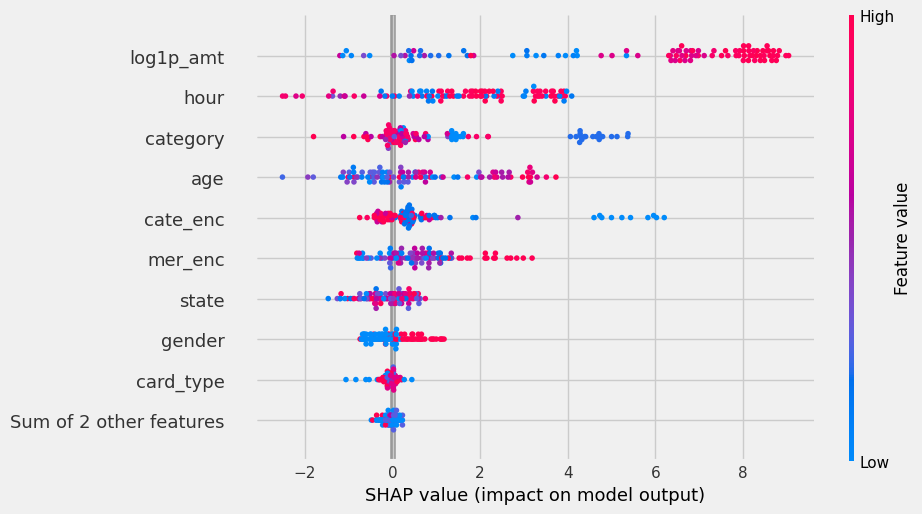

In [53]:
shap.initjs()
shap.plots.beeswarm(shap_values)

Model is confusing about category, state, card_type feature in making decision  


In [57]:
params_grid = {
    "n_estimators": np.arange(200,500, 100),
    "max_depth": np.arange(6, 9, 1),
    "eta": np.arange(0.1, 0.4, 0.1),
    "alpha": np.arange(0.1, 0.6, 0.1)
}

In [58]:
remove_col = remove_col + ['category','state','card_type']
for i in range(1):
  cv_train(i, model = 'random_search', params=params_grid, iters = 7, remove_col = remove_col)

features:  ['gender', 'age', 'hour', 'is_elder', 'cate_enc', 'card_enc', 'mer_enc', 'log1p_amt']
Fitting 5 folds for each of 7 candidates, totalling 35 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[05:48:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.



Best score: 0.9967233005088735
Best parameters set:
	alpha: 0.5
	eta: 0.1
	max_depth: 6
	n_estimators: 200


In [60]:
for i in range(5):
  cv_train(i, model = 'xgb', remove_col = remove_col)

features:  ['gender', 'age', 'hour', 'is_elder', 'cate_enc', 'card_enc', 'mer_enc', 'log1p_amt']
Fold: 0, AUC = 0.9966766414876357
test auc score is:  0.9955488952681739
report on fold: 0
accuracy: 1.00, sensitivity: 0.79, specificity:  1.00, precision: 0.92
----------

features:  ['gender', 'age', 'hour', 'is_elder', 'cate_enc', 'card_enc', 'mer_enc', 'log1p_amt']
Fold: 1, AUC = 0.9969376094516282
test auc score is:  0.9960500944138181
report on fold: 1
accuracy: 1.00, sensitivity: 0.78, specificity:  1.00, precision: 0.92
----------

features:  ['gender', 'age', 'hour', 'is_elder', 'cate_enc', 'card_enc', 'mer_enc', 'log1p_amt']
Fold: 2, AUC = 0.9972657601948061
test auc score is:  0.9958407402768952
report on fold: 2
accuracy: 1.00, sensitivity: 0.78, specificity:  1.00, precision: 0.93
----------

features:  ['gender', 'age', 'hour', 'is_elder', 'cate_enc', 'card_enc', 'mer_enc', 'log1p_amt']
Fold: 3, AUC = 0.9966455063952047
test auc score is:  0.9954675126850843
report on fold: 3

well done, we managed to increase in both recall and precision score

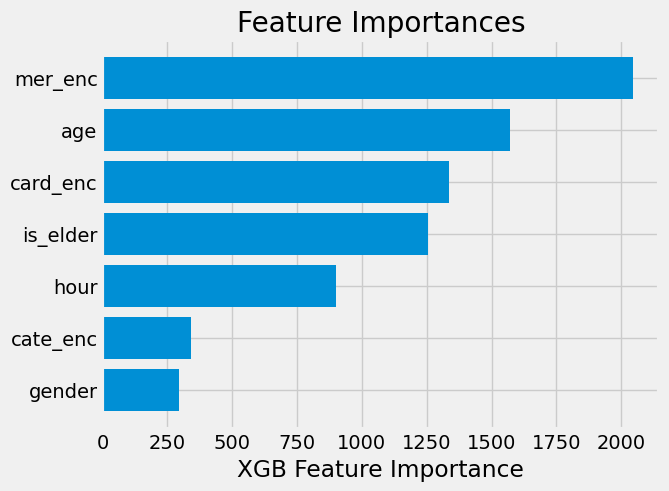

In [61]:
col = ['gender', 'age', 'hour', 'is_elder', 'cate_enc', 'card_enc', 'mer_enc', 'log1p_amt']
show_features(log_xgb, col, fold = 0)

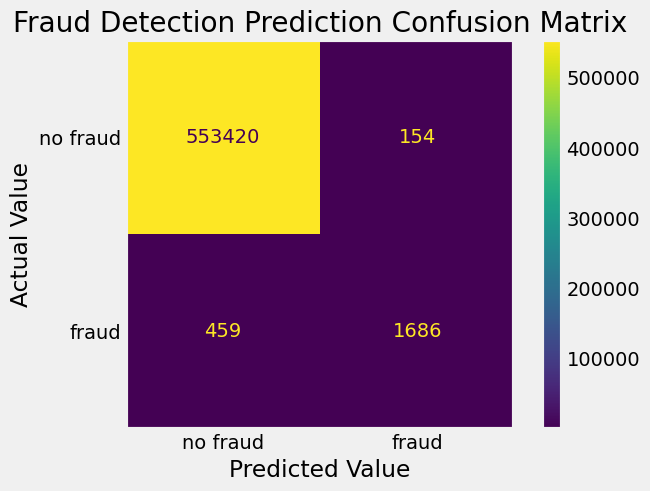

In [62]:
#cm = metrics.confusion_matrix(test_df.is_fraud.values, test_preds_notproba)
cmplot = metrics.ConfusionMatrixDisplay(
    log_cm[0],
    display_labels= ['no fraud', 'fraud'],

)
cmplot.plot()
cmplot.ax_.\
  set(title='Fraud Detection Prediction Confusion Matrix',
  xlabel='Predicted Value', ylabel='Actual Value')
plt.grid(False)